<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#UHS1–4-EA+AA-Meta-Analysis-for-HIV-Acquisition" data-toc-modified-id="UHS1–4-EA+AA-Meta-Analysis-for-HIV-Acquisition-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>UHS1–4 EA+AA Meta-Analysis for HIV Acquisition</a></span></li><li><span><a href="#Download-Data-&amp;-Create-Directory-Structure" data-toc-modified-id="Download-Data-&amp;-Create-Directory-Structure-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Download Data &amp; Create Directory Structure</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#cross-ancestry" data-toc-modified-id="cross-ancestry-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>cross-ancestry</a></span></li></ul></li><li><span><a href="#Code" data-toc-modified-id="Code-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Code</a></span><ul class="toc-item"><li><span><a href="#methods" data-toc-modified-id="methods-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>methods</a></span></li><li><span><a href="#Secondary-scripts" data-toc-modified-id="Secondary-scripts-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Secondary scripts</a></span><ul class="toc-item"><li><span><a href="#merge_metal" data-toc-modified-id="merge_metal-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>merge_metal</a></span></li><li><span><a href="#qsub_metal_v2.sh" data-toc-modified-id="qsub_metal_v2.sh-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>qsub_metal_v2.sh</a></span></li></ul></li></ul></li><li><span><a href="#Sandbox" data-toc-modified-id="Sandbox-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Sandbox</a></span></li><li><span><a href="#Upload-to-S3" data-toc-modified-id="Upload-to-S3-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Upload to S3</a></span></li></ul></div>

# UHS1–4 EA+AA Meta-Analysis for HIV Acquisition
**Author:** Jesse Marks <br>
**Results**: The results of this meta-analysis will be stored on AWS S3 at: `s3:///rti-hiv/meta_new/014_UHS1234`<br>
**GitHub Issue:** [#97](https://github.com/RTIInternational/bioinformatics/issues/97)

# Download Data & Create Directory Structure

In [ ]:
baseD=/shared/jmarks/hiv/meta

## Download data from S3

## Create directory structure then mv data over to respective directories
mkdir -p $baseD/data/uhs1234/{1df,2df}/{ea,aa}
mkdir -p $baseD/results/uhs1234/{1df,2df}/001/{processing,final}

## unzip data

# Results

## cross-ancestry
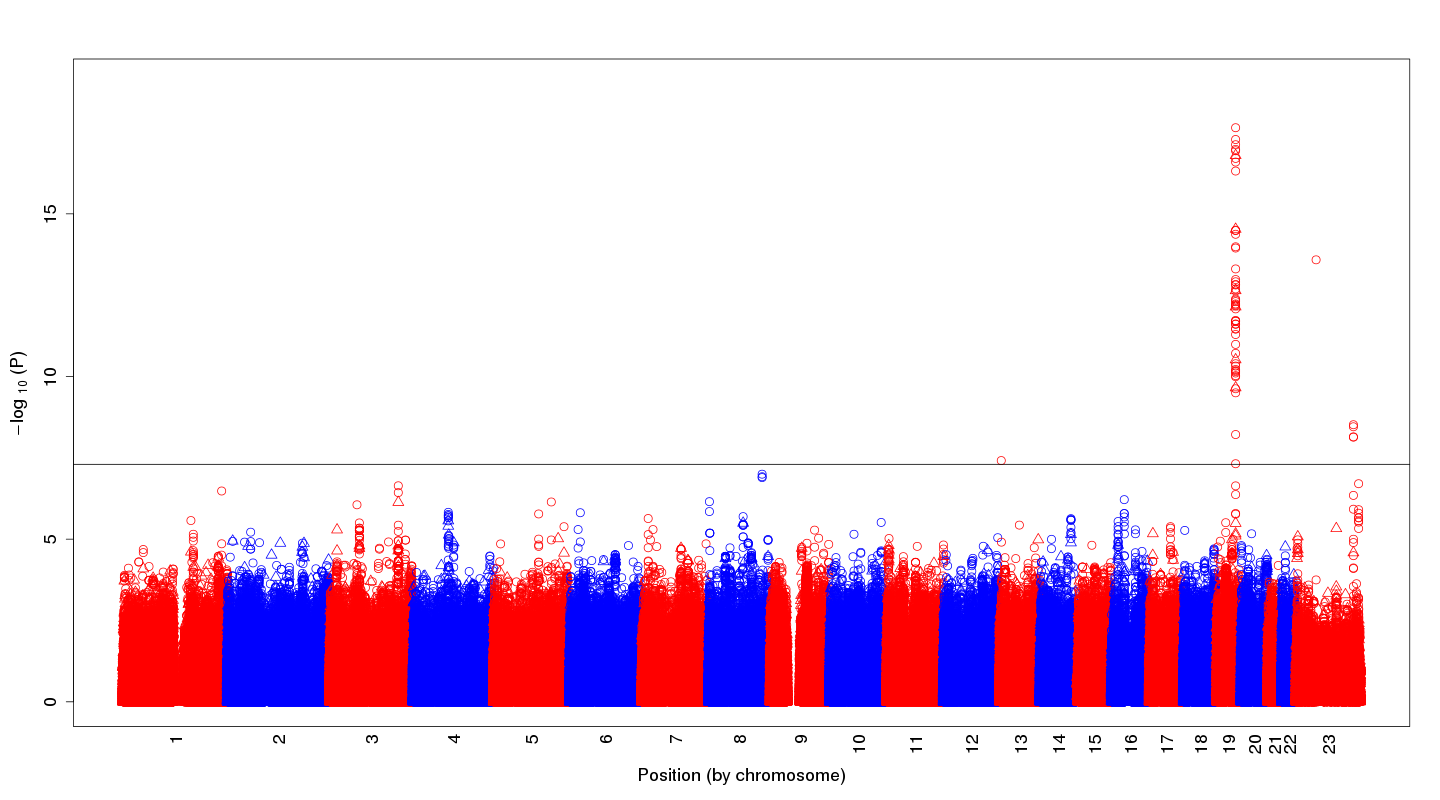
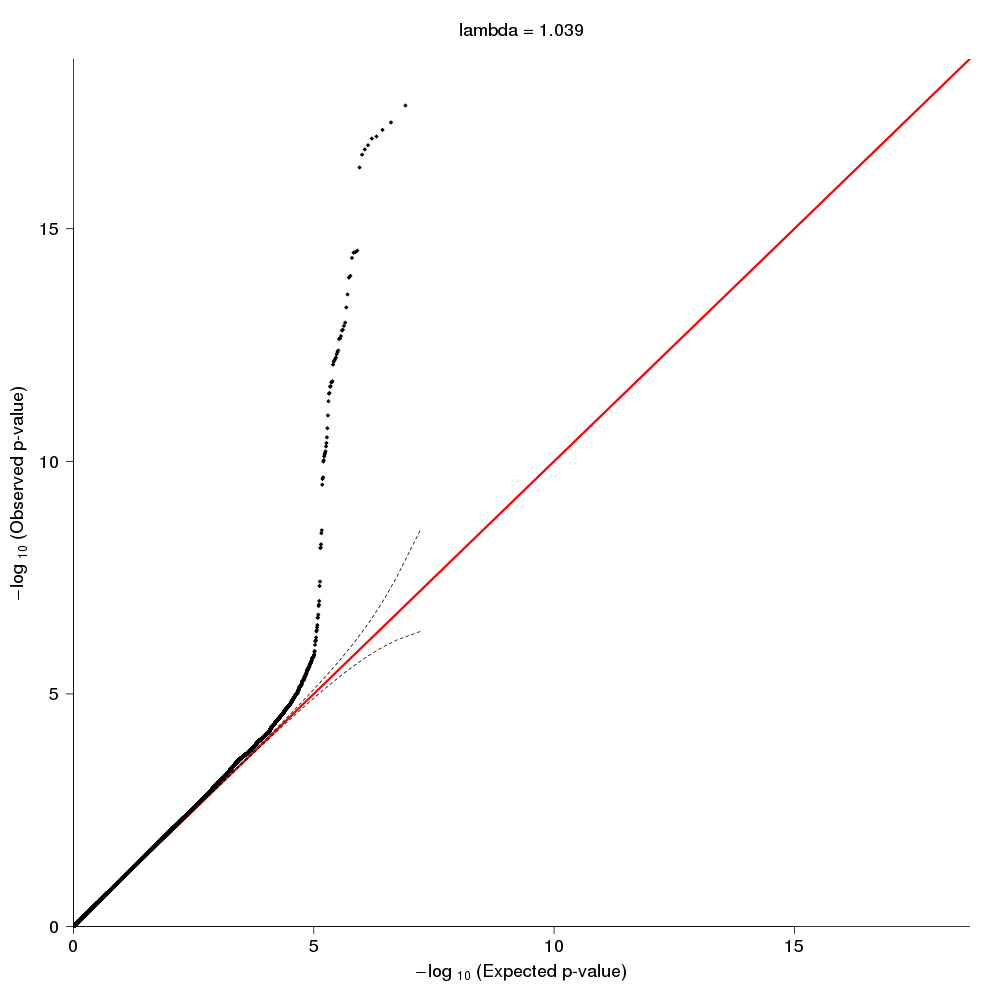

In [ ]:
library("IRdisplay")
display_png(file="C://Users/Jess/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/meta/002/uhs1234_hiv_acquisition_1df_meta_analysis_afr+eur.1df.snps+indels.manhattan.png", width=800, height=800)
display_png(file="C://Users/Jess/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/meta/002/uhs1234_hiv_acquisition_1df_meta_analysis_afr+eur.1df.snps+indels.qq.png", width=800, height=800)

# Code
Below are the methods to perform the meta-analysis in the AWS environment. The main parts that need modified are the paths to the cohorts' data which has been modified. For example, the R section at the end on lines 315 and 316.

Also note that we are converting everything to the 1000 Genome Phase 3 format and therefore we will include the script for performing this below.

## methods
Perform meta-analysis with METAL and produce the Manhattan and QQ plots.

In [ ]:
df="1df"
study="uhs1234"
version="002"
filePrefix="${study}_hiv_acquisition_${df}_meta_analysis_afr+eur"
outDir="/shared/jmarks/hiv/meta/results/${study}_${df}/$version"
dataDir="/shared/jmarks/hiv/meta/data"
maxchr=24  # 23 or 24 (add one)

mkdir -p $outDir/{processing,final}

# functions to create cohort paths. arg1="base/directory/path" arg2="chromosome#"
uhs1234_ea() { echo $1/uhs1234/$df/ea/uhs1234.ea.$df.1000G_p3.chr$2.HIV_ACQ~SNP+AGE+SEX+PC1+PC9+PC10.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats ;}
uhs1234_aa() { echo $1/uhs1234/$df/aa/uhs1234.aa.$df.1000G_p3.chr$2.HIV_ACQ~SNP+AGE+SEX+PC10+PC9+PC2+PC6.maf_gt_0.01_subject+afr.rsq_gt_0.30.stats ;}


#NOTE, the following loop only works running in a new vim shell without any
# predefined function. You could do this manually if you otherwise wanted to.
# create capitalized cohort labels based off of the above functions
cohortLabels=""
for function in $(compgen -A function);do
    cohortLabels+=$(echo ${function^^})
    cohortLabels+=" "
done

# remove "MODULE" function
echo $cohortLabels
cohortLabels=${cohortLabels//"MODULE"}
echo $cohortLabels

# the cohort labels below were retrieved from running the loop above
#cohortLabels="UHS1234_AA UHS1234_EA"
################################################################################
################################################################################

##name    chrom   position        A1      A2      Freq1   MAF     Quality Rsq     n       Mean_predictor_allele   beta_SNP_addA1  sebeta_SNP_addA1      chi2_SNP_add     chi     p       or_95_percent_ci ##

if [ $df == "1df" ];then
    pv="p"
    std="STDERR"
elif [ $df == "2df" ]; then
    pv="p_2df"
    std="INTERACTION"
fi

### START METAL analysis ###
#for (( chr=1; chr<${maxchr}; chr++)); do
#    my_string=""
#    for cohort in ${cohortLabels};do
#        string_fun() { echo "--PROCESS" $(${cohort,,} $1 $2); }
#        my_string+=$(string_fun $dataDir $chr)
#        my_string+=" "
#    done
#    bash ~/bin/qsub_metal.sh \
#        --SCHEME $std \
#        --PVALUE $pv \
#        --MARKER name \
#        --ALLELE A1 A2 \
#        --EFFECT beta_SNP_addA1 \
#        --STDERR sebeta_SNP_addA1 \
#        --GENOMICCONTROL OFF \
#        ${my_string} \
#        --OUTFILE $outDir/processing/${filePrefix}.chr$chr.$df .metal \
#        --ANALYZE HETEROGENEITY \
#        --script_prefix $outDir/processing/${filePrefix}.chr$chr.$df \
#        --mem 3.8 \
#        --priority 0
#done

## START Merge ProbABEL and METAL results ###
for (( chr=1; chr<${maxchr}; chr++ )); do
    my_string=""
    for cohort in ${cohortLabels};do
        string_fun() { echo $(${cohort,,} $1 $2); }
        my_string+=$(string_fun $dataDir $chr)
        my_string+=" "
    done

  /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name meta_${chr} \
    --script_prefix $outDir/processing/${filePrefix}.chr$chr.$df \
    --mem 15 \
    --nslots 2 \
    --priority 0 \
    --program python ~/bin/merge_probabel_metal_v02.py \
        --metal $outDir/processing/${filePrefix}.chr$chr.$df.metal \
        --probabel \
        ${my_string} \
        --probabel_labels ${cohortLabels} \
        --out $outDir/final/${filePrefix}.chr$chr.$df 
done
### END Merge ProbABEL and METAL results ###

# Check for completion (should return/print out nothing)
for (( chr=1; chr<${maxchr}; chr++ )); do
  file=$outDir/processing/${filePrefix}.chr$chr.$df.qsub.log
  if [ -f $file ]
  then
    logLineCount=$(wc -l $file | perl -lane 'print $F[0];')
    if [ $logLineCount -eq 0 ]; then
      echo $file empty
    else
      tail -n 1 $file |
        perl -ne 'chomp; if (!/Done$/) { print "'$file'\n".$_."\n"; }'
    fi
  else
    echo $file missing
  fi
done


### START Generate plots ###
# create SNP table for input to plotting script
outFile=$outDir/processing/${filePrefix}.$df.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outFile
for (( chr=1; chr<${maxchr}; chr++ )); do
    inFile=$outDir/final/${filePrefix}.chr$chr.$df  
    echo Processing $inFile
    tail -n +2 $inFile |
    perl -lne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+\S+\s+\S+\s+(\S+)/;
                if (($4 eq "a" || $4 eq "c" || $4 eq "g" || $4 eq "t") && ($5 eq "a" || $5 eq "c" || $5 eq "g" || $5 eq "t")) {
                  print join("\t",$1,$2,$3,$6,"snp");
                } else {
                  print join("\t",$1,$2,$3,$6,"indel");
                }' >> $outFile
done


# generate plots
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots \
    --script_prefix $outDir/processing/${filePrefix}.$df.plots \
    --mem 15 \
    --priority 0 \
    --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
    --in $outDir/processing/${filePrefix}.$df.table \
    --in_chromosomes autosomal_nonPAR \
    --in_header \
    --out $outDir/processing/${filePrefix}.$df\
    --col_id VARIANT_ID \
    --col_chromosome CHR \
    --col_position POSITION \
    --col_p P \
    --col_variant_type TYPE \
    --generate_snp_indel_manhattan_plot \
    --manhattan_odd_chr_color red \
    --manhattan_even_chr_color blue \
    --manhattan_points_cex 1.5 \
    --manhattan_cex_lab 1.5 \
    --manhattan_cex_axis 1.5 \
    --generate_snp_indel_qq_plot \
    --qq_lines \
    --qq_points_bg black \
    --qq_lambda

mv $outDir/processing/*.png \
 $outDir/final
### END Generate plots ###

                  
## remove singleton SNP/indels (snps founnd in only one cohort) ###
# python script
python
study = "uhs1234"
df = "1df"
filePrefix = "uhs1234_hiv_acquisition_1df_meta_analysis_afr+eur"
outDir = "/shared/jmarks/hiv/meta/results/uhs1234_1df/002/final/"

filePrefix += '.chr'
for chrom in range(1,24):
    print("Processing chromosome " + str(chrom) + "...")
    inF = open(outDir + filePrefix + str(chrom) + "." + df, "r")
    outF = open(outDir + filePrefix + str(chrom) + ".exclude_singletons." + df, "w")
    firstLine = inF.readline()
    outF.write(firstLine)
    line = inF.readline()
    while(line):
        tmp = line.split()
        if(sum([d != "?" for d in tmp[8]]) > 1):
            outF.write(line)
        line = inF.readline()
    inF.close()
    outF.close()
## end python script


### START Generate plots with singletons removed###
# create SNP table for input to plotting script
outFile=$outDir/processing/${filePrefix}.exclude_singletons.$df.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outFile
for (( chr=1; chr<${maxchr}; chr++ )); do
    inFile=$outDir/final/${filePrefix}.chr$chr.exclude_singletons.$df
    echo Processing $inFile
    tail -n +2 $inFile |
        perl -lne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+\S+\s+\S+\s+(\S+)/;
            if (($4 eq "a" || $4 eq "c" || $4 eq "g" || $4 eq "t") && ($5 eq "a" || $5 eq "c" || $5 eq "g" || $5 eq "t")) {
              print join("\t",$1,$2,$3,$6,"snp");
            } else {
              print join("\t",$1,$2,$3,$6,"indel");
            }' >> $outFile
done


# Generate plots with singletons removed
/shared/bioinformatics/software/scripts/qsub_job.sh \
  --job_name gwas_plots_no_singletons \
  --script_prefix $outDir/processing/${filePrefix}.exclude_singletons.$df.plots \
  --mem 15 \
  --priority 0 \
  --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
  --in $outDir/processing/${filePrefix}.exclude_singletons.$df.table \
  --in_chromosomes autosomal_nonPAR \
  --in_header \
  --out $outDir/processing/${filePrefix}.exclude_singletons.$df \
  --col_id VARIANT_ID \
  --col_chromosome CHR \
  --col_position POSITION \
  --col_p P \
  --col_variant_type TYPE \
  --generate_snp_indel_manhattan_plot \
  --manhattan_odd_chr_color red \
  --manhattan_even_chr_color blue \
  --manhattan_points_cex 1.5 \
  --manhattan_cex_lab 1.5 \
  --manhattan_cex_axis 1.5 \
  --generate_snp_indel_qq_plot \
  --qq_lines \
  --qq_points_bg black \
  --qq_lambda


# plot with ylim
/shared/bioinformatics/software/scripts/qsub_job.sh \
  --job_name gwas_plots_no_singletons_ylim \
  --script_prefix $outDir/processing/${filePrefix}.exclude_singletons.$df.ylim_9.plots \
  --mem 15 \
  --priority 0 \
  --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
  --in $outDir/processing/${filePrefix}.exclude_singletons.$df.table \
  --in_chromosomes autosomal_nonPAR \
  --in_header \
  --out $outDir/processing/${filePrefix}.exclude_singletons.ylim_9.$df \
  --col_id VARIANT_ID \
  --col_chromosome CHR \
  --col_position POSITION \
  --col_p P \
  --col_variant_type TYPE \
  --generate_snp_indel_manhattan_plot \
  --manhattan_odd_chr_color red \
  --manhattan_even_chr_color blue \
  --manhattan_points_cex 1.5 \
  --manhattan_cex_lab 1.5 \
  --manhattan_cex_axis 1.5 \
  --generate_snp_indel_qq_plot \
  --qq_lines \
  --qq_points_bg black \
  --qq_lambda \
  --manhattan_ylim 9


mv $outDir/processing/*.png \
 $outDir/final

### END Generate plots ###


### START Filter by p-value  < 0.001 ###
outFile=$outDir/processing/${filePrefix}.$df.p_lte_0.001
head -n 1 $outDir/final/${filePrefix}.chr22.$df > $outFile
for (( chr=1; chr<${maxchr}; chr++ )); do
  inFile=$outDir/final/${filePrefix}.chr$chr.$df
  echo Processing $inFile
  tail -n +2 $inFile |
    perl -lane 'if ($F[7] <= 0.001) { print; }' >> $outFile
done


# Filter by p-value < 0.001 (exclude_singletons)
outFile=$outDir/processing/${filePrefix}.exclude_singletons.$df.p_lte_0.001
head -n 1 $outDir/final/${filePrefix}.chr22.exclude_singletons.$df > $outFile
for (( chr=1; chr<${maxchr}; chr++ )); do
  inFile=$outDir/final/${filePrefix}.chr$chr.exclude_singletons.$df
  echo Processing $inFile
  tail -n +2 $inFile |
    perl -lane 'if ($F[7] <= 0.001) { print; }' >> $outFile
done

# end p-value filtering


# Sort p-value filtered file (Rscript)
R
filePrefix <- "uhs1234_hiv_acquisition_1df_meta_analysis_afr+eur"
outDir <- "/shared/jmarks/hiv/meta/results/uhs1234_1df/002"
df <- "1df"

inData=read.table(paste(sep="", outDir, "/processing/", filePrefix, ".", df, ".p_lte_0.001"), header = TRUE)
outData = inData[order(inData$P.value),]
write.csv(outData, file=paste(sep="", outDir, "/final/", filePrefix, ".", df, ".p_lte_0.001.csv"), row.names = FALSE, quote=FALSE)

inData2 = read.table(paste(sep="", outDir, "/processing/", filePrefix, ".exclude_singletons.", df, ".p_lte_0.001"), header = TRUE)
outData2 = inData2[order(inData2$P.value),]
write.csv(outData2, file=paste(sep="", outDir, "/final/", filePrefix, ".exclude_singletons.", df, ".p_lte_0.001.csv"), row.names = FALSE, quote=FALSE)
### END Filter by p-value ###



### Create FUMA file ###
base_dir=$outDir/final
# Chr =
# Position
# MarkerName
# P-value
# Allele1
# Allele2
# Effect
# StdErr

#MarkerName chr position Allele1 Allele2 Effect StdErr P-value Direction HetISq HetChiSq HetDf HetPVal
in_file() {
echo $1/uhs1234_hiv_acquisition_${df}_meta_analysis_afr+eur.chr$2.exclude_singletons.$df
}
outfile=$base_dir/uhs1234_hiv_acquisition_meta_analysis.afr+eur.exclude_singletons.$df.ALL_CHR.FUMA
echo $(in_file $base_dir 1)

# print header to file
awk '{print $1,$2,$3,$4,$5,$6,$7,$8;exit}'\
    $(in_file $base_dir 1) > $outfile
for chr in {1..23}; do
    echo processing chr$chr
    awk 'NR>=2{print $1,$2,$3,$4,$5,$6,$7,$8}'\
     $(in_file $base_dir $chr) >> $outfile
done

### End FUMA creation ###

## Secondary scripts
These were scripts called in the methods file above.

### merge_metal

In [ ]:
import gzip, sys, os, operator

# function parses input arguments
# required arguments: --metal
#                                        --probabel
#                                        --probabel_labels
#                                        --out
def parseArguments(args):
        while(len(args) > 0):
                # input metal file name (full path)
                if(args[0] == '--metal'):
                        metalFName = args[1]
                        args = args[2:]

                # a list of input probabel file names (full path)
                elif(args[0] == '--probabel'):
                        args = args[1:]
                        probabelFList = []
                        while(len(args)>0 and args[0][:2] != '--'):
                                probabelFList.append(args[0])
                                args = args[1:]

                # a list of probabel labels
                elif(args[0] == '--probabel_labels'):
                        args = args[1:]
                        labelsList = []
                        while(len(args)>0 and args[0][:2] != '--'):
                                labelsList.append(args[0])
                                args = args[1:]

                # output merged file name (full path)
                elif(args[0] == '--out'):
                        outFName = args[1]
                        args = args[2:]

                # other arguments unused
                else:
                        sys.exit('Unused arguments: ' + ' '.join(args))

        # check if missing required arguments
        if('metalFName' not in locals() or 'probabelFList' not in locals() or 'labelsList' not in locals() or 'outFName' not in locals()):
                sys.exit('Missing at least one required argument. Please specify --metal, --probabel, --probabel_labels, --out')

        # check if length of probabel files equals length of probabel labels
        if(len(probabelFList) != len(labelsList)):
                sys.exit('Length of probabel files does not match length of probabel labels.')

        return (metalFName, outFName, probabelFList, labelsList)

# function sort the input probabel file by position
def maybeSort(fname):
        if(fname[-7:] == '.sorted'):
                return fname
        else:
                # check if a sorted file is available
                if(os.path.exists(fname + '.sorted')):
                        print 'Using already sorted file: ' + fname + '.sorted'
                        return fname + '.sorted'
                #if(os.path.exists(fname + '.sorted.gz')):
                #       os.system('rm ' + fname + '.sorted.gz')
                # sort by position
                inF = open(fname, 'r')
                header = inF.readline().split()
                if('position' in header):
                        posIndex = str(header.index('position') + 1)
                elif('pos' in header):
                        posIndex = str(header.index('pos') + 1)
                print 'Sorting file: ' + fname
                cmd = 'sort -k' + posIndex + 'n,' + posIndex + ' ' + fname + ' > ' + fname + '.sorted'
                os.system(cmd)
                return fname + '.sorted'

# one marker represents a row,
# use .output() function to write to file
class Marker:
        def __init__(self, line):
                tmp = line.split()
                self.name = tmp[0]
                self.chr = '.'
                self.pos = '.'
                self.content = tmp[1:]
                self.length = len(self.content)

        def addChrPos(self, line, chrIndex, posIndex):
                tmp = line.split()
                newChr = tmp[chrIndex]
                newPos = tmp[posIndex]

                if(self.chr == '.'):
                        self.chr = newChr
                elif(self.chr != newChr):
                        print('Chromosome for marker ' + self.name + ' does not match.')

                if(self.pos == '.'):
                        self.pos = newPos
                elif(self.pos != newPos):
                        print('Position for marker ' + self.name + ' does not match.')

        def output(self):
                return(' '.join([self.name, self.chr, self.pos]) + ' ' + ' '.join(self.content))
# extract chr and pos information from probabel file, save to metalDict
def extractNameChrPos(metalDict, probabelFName):
        probabelF = open(probabelFName, 'r')
        header = probabelF.readline().split()

        nameIndex = -1
        chrIndex = -1
        posIndex = -1

        if('name' in header):
                nameIndex = header.index('name')
        elif('marker_name' in header):
                nameIndex = header.index('marker_name')
        elif('markername' in header):
                nameIndex = header.index('markername')

        if('chrom' in header):
                chrIndex = header.index('chrom')
        elif('chr' in header):
                chrIndex = header.index('chr')

        if('position' in header):
                posIndex = header.index('position')
        elif('pos' in header):
                posIndex = header.index('pos')

        if(nameIndex == -1 or chrIndex == -1 or posIndex == -1):
                print probabelFName
                print header

        tmpSet = set()
        for line in probabelF.readlines():
                tmp = line.split()
                tmpSet.add(tmp[nameIndex])
                if(metalDict.get(tmp[nameIndex], 'NA') == 'NA'):
                        continue
                metalDict[tmp[nameIndex]].addChrPos(line, chrIndex, posIndex)
        probabelF.close()
        return tmpSet

# add metal content to dictionary
def addMetalToDict(d, fname):
        if(fname[-2:] == 'gz'):
                inF = gzip.open(fname, 'r')
        else:
                inF = open(fname, 'r')
        markerP = {}
        header = inF.readline()
        pIndex = header.split().index('P-value')

        for line in inF.readlines():
                tmp = line.split()
                marker = tmp[0]
                d[marker] = Marker(line)
                markerP[marker] = float(tmp[pIndex])

        inF.close()

        return markerP

# function extract header from probabel files
def extractHeaders(probabelStream):
        headers = []
        for i in range(len(probabelStream)):
                headers.append(probabelStream[i].readline())
        return headers

# function construct header from metal files and probabel files
def constructHeader(metalFName, probabelHeaders, labelsList):
        if(metalFName[-2:] == 'gz'):
                metalF = gzip.open(metalFName, 'r')
        else:
                metalF = open(metalFName, 'r')
        header = metalF.readline().split()
        header.insert(1, 'position')
        header.insert(1, 'chr')
        metalF.close()

        for i in range(len(labelsList)):
                tmp = probabelHeaders[i].split()
                for t in tmp:
                        if(t not in ['name', 'marker_name', 'markername', 'chrom', 'chr', 'position', 'pos']):
                                header.append(t + '.' + labelsList[i])
        return ' '.join(header)

# extract marker name index and position index from header
def extractNameIndexPosIndex(probabelHeaders):
        nameIndex = []
        posIndex = []
        lengths = []
        for header in probabelHeaders:
                tmp = header.split()
                if('name' in tmp):
                        nameIndex.append(tmp.index('name'))
                elif('marker_name' in tmp):
                        nameIndex.append(tmp.index('marker_name'))
                elif('markername' in tmp):
                        nameIndex.append(tmp.index('markername'))
                else:
                        nameIndex.append(-1)
                if('position' in tmp):
                        posIndex.append(tmp.index('position'))
                elif('pos' in tmp):
                        posIndex.append(tmp.index('pos'))
                else:
                        posIndex.append(-1)
                lengths.append(len(tmp) - posIndex[-1] - 1)
        return (nameIndex, posIndex, lengths)

def processThisMarker(markerName, metalDict, probabelStream, markerNames, buffer, probabelHeaders):
        nameIndex, posIndex, lengths = extractNameIndexPosIndex(probabelHeaders)
        # content from metal
        thisMarker = metalDict[markerName]
        line = thisMarker.output() # metal content added
        for i in range(len(probabelStream)):
                if(thisMarker.name in markerNames[i]):
                        # first check buffer
                        if(buffer[i].get(thisMarker.name, 'NA') != 'NA'):
                                line = line + ' ' + ' '.join(buffer[i][thisMarker.name])
                                del buffer[i][thisMarker.name]
                        # not in buffer, then read in from stream
                        else:
                                newLine = probabelStream[i].readline()
                                tmp = newLine.split()
                                # if the next element is not the one looking for, deposite in buffer
                                while(newLine and tmp[nameIndex[i]] != thisMarker.name):
                                        buffer[i][tmp[nameIndex[i]]] = tmp[posIndex[i]+1:]
                                        newLine = probabelStream[i].readline()
                                        tmp = newLine.split()

                                # now this is the marker
                                line = line + ' ' + ' '.join(tmp[posIndex[i]+1:])
                else:
                        for j in range(lengths[i]):
                                line = line + ' NA'
        return line

def checkOutput(outFName):
        with open(outFName) as outF:
                header = outF.readline()
                headerLength = len(header.split())
                line = outF.readline()
                while(line):
                        if(len(line.split()) != headerLength):
                                return "Fail"
                        line = outF.readline()
                return "Succeed"

# the main function
if __name__ == "__main__":
        metalFName, outFName, probabelFList, labelsList = parseArguments(sys.argv[1:])

        for i in range(len(probabelFList)):
                probabelFList[i] = maybeSort(probabelFList[i])

        # read in metal file
        # construct a dictionary to hold all metal results
        # key is the marker name, value is a Marker class object
        metalDict = {}
        markerP = addMetalToDict(metalDict, metalFName) # markerP - meta analyses p-value

        # first loop through all probabel files to add chr and position information
        # at the same time, keep a record of all marker names
        markerNames = []
        for probabelFName in probabelFList:
                tmpSet = extractNameChrPos(metalDict, probabelFName)
                markerNames.append(tmpSet)

        # sort marker by position
        markerPos = {}
        for m in metalDict.keys():
                try:
                        markerPos[m] = int(metalDict[m].pos)
                except Exception:
                        pass
        sortedMarker = sorted(markerPos.items(), key=operator.itemgetter(1))

        # loop through all probabel files second times
        # this time, keep the input stream
        probabelStream = []
        for probabelFName in probabelFList:
                probabelStream.append(open(probabelFName))

        # first pass - create the output file
        # header - first line from stream read
        outF = open(outFName, 'w')
        probabelHeaders = extractHeaders(probabelStream)
        outF.write(constructHeader(metalFName, probabelHeaders, labelsList) + '\n')

        # content - read subsequent lines
 # a buffer stores markers that are out of order
        buffer = []
        for i in probabelHeaders:
                buffer.append({})
        for m in sortedMarker:
                line = processThisMarker(m[0], metalDict, probabelStream, markerNames, buffer, probabelHeaders)
                outF.write(line + '\n')

        outF.close()

        # check output number of columns

        while(checkOutput(outFName) == 'Fail'):
                # header - first line from stream read
                outF = open(outFName, 'w')
                probabelHeaders = extractHeaders(probabelStream)
                outF.write(constructHeader(metalFName, probabelHeaders, labelsList) + '\n')

                # content - read subsequent lines
                # a buffer stores markers that are out of order
                buffer = []
                for i in probabelHeaders:
                        buffer.append({})
                for m in sortedMarker:
                        line = processThisMarker(m[0], metalDict, probabelStream, markerNames, buffer, probabelHeaders)
                        outF.write(line + '\n')

                outF.close()

        print 'Done'

### qsub_metal_v2.sh
I had to modify lines 70 and 71 to reflect the parallel processing (multi-threading) environment in the AWS environment - symmetric multiprocessing (smp)

In smp all of the cores act as one through the operating system. 

In [ ]:
#!/bin/sh

metalScript="#!/shared/bioinformatics/software/third_party/metal_v3.25.2011/bin/metal\n\n"
outFile=""
finalOutFile=""
scriptPrefix=""
mem=3.8
priority=0

while [ "$1" != "" ];
do
        if [ "$1" == "--MARKER" ] || [ "$1" == "--EFFECT" ] || [ "$1" == "--PVALUE" ] || [ "$1" == "--WEIGHT" ] || [ "$1" == "--GENOMICCONTROL" ] || [ "$1" == "--PROCESS" ] || [ "$1" == "--SCHEME" ] || [ "$1" == "--STDERR" ]; then
                metalScript=$metalScript$(echo $1 | sed 's/--//')" "$2"\n"
                shift
        elif [ "$1" == "--ALLELE" ] || [ "$1" == "--OUTFILE" ]; then
                metalScript=$metalScript$(echo $1 | sed 's/--//')" "$2" "$3"\n"
                if [ "$1" == "--OUTFILE" ]; then
                        outFile=$2"1"$3
                        finalOutFile=$2$3
                fi
                shift
                shift
        elif [ "$1" == "--ANALYZE" ]; then
                if [ "$2" == "HETEROGENEITY" ]; then
                        metalScript=$metalScript"ANALYZE HETEROGENEITY\n"
                        shift
                else
                        metalScript=$metalScript"ANALYZE\n"
                fi
        else
                case $1 in
                        --script_prefix )                       shift
                                                                                scriptPrefix=$1
                                                                                ;;
                        --mem )                                         shift
                                                                                mem=$1
                                                                                ;;
                        --priority )                            shift
                                                                                priority=$1
                                                                                ;;
                esac
        fi
        shift
done
metalScript=$metalScript"QUIT\n"
fileMetalScript=$scriptPrefix".metal.sh"
echo -e $metalScript > $fileMetalScript
chmod 775 $fileMetalScript

fileQsubScript=$scriptPrefix".metal.qsub.sh"
fileQsubScriptLog=$scriptPrefix".metal.qsub.log"
fileQsubScriptError=$scriptPrefix".metal.qsub.error"
echo \#$ -S /bin/bash > $fileQsubScript
echo \#$ -v LD_LIBRARY_PATH >> $fileQsubScript
echo \#  >> $fileQsubScript
echo \# >> $fileQsubScript
echo \#$ -l h_rt=600:00:00  >> $fileQsubScript
echo \# >> $fileQsubScript
echo \# >> $fileQsubScript
echo \# Job name  >> $fileQsubScript
echo \#$ -N METAL >> $fileQsubScript
echo \# >> $fileQsubScript
echo \# Use current working directory >> $fileQsubScript
echo \#$ -cwd >> $fileQsubScript
echo \# >> $fileQsubScript
echo \# Join stdout and stderr >> $fileQsubScript
echo \#$ -j y >> $fileQsubScript
echo \# >> $fileQsubScript
echo \# pe request for MPICH2. Set your number of processors here.  >> $fileQsubScript
echo \# SMP stands for "Shared Memory Jobs" >> $fileQsubScript
echo \#$ -pe smp 1 >> $fileQsubScript
echo \# >> $fileQsubScript
echo \# Run job through bash shell >> $fileQsubScript
echo \#$ -S /bin/bash >> $fileQsubScript
echo \# >> $fileQsubScript
echo \# The following is for reporting only. It is not really needed >> $fileQsubScript
echo \# to run the job. It will show up in your output file. >> $fileQsubScript
echo echo \"Got \$NSLOTS processors.\" >> $fileQsubScript
echo $fileMetalScript >> $fileQsubScript
echo mv $outFile $finalOutFile >> $fileQsubScript
echo mv $outFile.info $finalOutFile.info >> $fileQsubScript

chmod 775 $fileQsubScript

vmem=`echo "$mem + 2" | bc`

qsub -q all.q -l mem_free=${mem}G,h_vmem=${vmem}G,h_rt=24:00:00 -p $priority -o $fileQsubScriptLog -e $fileQsubScriptError $fileQsubScript


# Sandbox
The Nelson dataset had a slightly different header that we are going to change to make consistent with the other datasets. We also remove the `Quality` field.

In [ ]:
### Bash ###
cd /home/ec2-user/jmarks/nicotine/meta/studies/nelson/ea
for file in *RSQ; do
    echo "Processing $file"
     cat $file | awk ' $8=""; {print $0}' > $file.filtered
done

################################################################################
### Python ###
from probabel_snp import *

base_dir = "/shared/jmarks/nicotine/meta/studies/nelson/ea"
for chrom in range(1,23):
    print("processing chr {}".format(chrom))
    in_fname = "{}/nelson.ea.1000G_p3.chr{}.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ.filtered".format(base_dir, chrom)
    out_fname = "{}.probabel".format(in_fname)
# 
    with open(in_fname, 'r') as inF, open(out_fname, 'w') as outF:
        header = inF.readline() 
        prob_header = get_probabel_header(sep = "\t")
        outF.write(prob_header + '\n')
#         
        line = inF.readline()
        while line:
            outF.write(line)
            line = inF.readline()
################################################################################

# Upload to S3
Be sure to zip up all results and corresponding documents before uploading to S3.

In [ ]:
# upload individual cohort GWAS results 
study_dir=/home/ec2-user/jmarks/nicotine/meta/studies
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name upload_ftnd_studies \
    --script_prefix aws_upload \
    --mem 15 \
    --nslots 2 \
    --priority 0 \
    --program aws s3 sync $study_dir s3://rti-nd/META/1df/20181108/data/studies/ 

# upload meta results
for ancestry in  {aa,ea,cross};do
    results_dir=/home/ec2-user/jmarks/nicotine/meta/results/$ancestry/20181108/final
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name s3_results_upload_$ancestry \
        --script_prefix ~/ftnd_results_uploads \
        --mem 15 \
        --nslots 3 \
        --priority 0 \
        --program aws s3 sync $results_dir s3://rti-nd/META/1df/20181108/results/$ancestry/

    # upload methods files
meth_dir=/home/ec2-user/jmarks/nicotine/meta/methods/$ancestry/
aws s3 sync ${meth_dir} s3://rti-nd/META/1df/20181108/methods/$ancestry --quiet &
done

aws s3 cp README s3://rti-nd/META/1df/20181108/README

In [ ]:
for chr in {1..23};do
    file=hiv_acquisition_1df_meta_analysis_uhs1-4_ea+wihs1_ea.chr$chr.1df.gz
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name upload.chr$chr \
        --script_prefix s3.chr$chr \
        --mem 10 \
        --nslots 2 \
        --priority 0 \
        --program aws s3 cp $file s3://rti-hiv/meta_new/019/results/stats/include_singletons/$file 
done